# Dense Model Approach
- In this model, I will add two dimensions to each record; one dimension will have question 1 and another dimension will have question 2.

## Read Data from CSV File

In [2]:
# Read Data
import pandas as pd
import numpy as np
import os

data = pd.read_csv('./questions.csv')

data.question1 = data.question1.astype(str)
data.question2 = data.question2.astype(str)

questions_1 = data.question1
questions_2 = data.question2
is_duplicate = data.is_duplicate
num_of_records = len(data)

## Preprocess Data
We will pad all sentences to 250 characters and tokenize them.

In [3]:
# Preprocess Data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 250

def get_sequences_padded(input_texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(input_texts)
    seq = tokenizer.texts_to_sequences(input_texts)
    seq = pad_sequences(seq, maxlen=maxlen)
    return seq

labels = np.asarray(is_duplicate).astype('float32')
questions_1_sequences = get_sequences_padded(questions_1)
questions_2_sequences = get_sequences_padded(questions_2)

print('Shape of questions_1_sequences tensor:', questions_1_sequences.shape)
print('Shape of questions_2_sequences tensor:', questions_2_sequences.shape)
print('Shape of labels tensor:', labels.shape)

/Users/harsimranb/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Shape of questions_1_sequences tensor: (404351, 250)
Shape of questions_2_sequences tensor: (404351, 250)
Shape of labels tensor: (404351,)


Now we will distribute the test and train size.  The test data will be 30% of the total data.

In [4]:
# Combine Questions 1 And 2 Into an input with multiple dimensions
test_size = int(num_of_records * 0.3)
train_size = num_of_records-test_size

train_data = np.ones((2, train_size, maxlen))
test_data = np.ones((2, test_size, maxlen))

train_data[0] = questions_1_sequences[test_size:]
train_data[1] = questions_2_sequences[test_size:]
test_data[0] = questions_1_sequences[:test_size]
test_data[1] = questions_2_sequences[:test_size]
train_labels = labels[test_size:]
test_labels = labels[:test_size]

# Swap 0 and 1 axis, so number of examples is axis 0.
train_data = np.swapaxes(train_data, 1, 0)
test_data = np.swapaxes(test_data, 1, 0)

print('Shape of train tensor:', train_data.shape)
print('Shape of test tensor:', test_data.shape)

Shape of train tensor: (202176, 2, 250)
Shape of test tensor: (202175, 2, 250)


## Build Model
Here we will build a small dense model for training.

In [28]:
# Build Model and Train
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(2,250)))
model.add(Dense(16, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# model.summary()

history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 161740 samples, validate on 40436 samples
Epoch 1/10
161740/161740 [==============================] - 4s 25us/step - loss: 4.8653 - acc: 0.6113 - val_loss: 3.6582 - val_acc: 0.6201
Epoch 2/10
161740/161740 [==============================] - 3s 20us/step - loss: 2.4916 - acc: 0.6217 - val_loss: 1.7265 - val_acc: 0.6720
Epoch 3/10
161740/161740 [==============================] - 3s 21us/step - loss: 1.0780 - acc: 0.6305 - val_loss: 0.7349 - val_acc: 0.6266
Epoch 4/10
161740/161740 [==============================] - 3s 19us/step - loss: 0.6911 - acc: 0.6498 - val_loss: 0.6407 - val_acc: 0.6905
Epoch 5/10
161740/161740 [==============================] - 3s 19us/step - loss: 0.6486 - acc: 0.6719 - val_loss: 0.6266 - val_acc: 0.6892
Epoch 6/10
161740/161740 [==============================] - 3s 19us/step - loss: 0.6418 - acc: 0.6769 - val_loss: 0.6337 - val_acc: 0.6832
Epoch 7/10
161740/161740 [==============================] - 3s 19us/step - loss: 0.6376 - acc: 0.6774 - val_loss: 0

## Evaludate Model
Upon evaluation of the current model, we reach a decent training and validation accuracy, of ~68%
The loss is also faily low and consistent.  Therefore, our model is not overfitting.

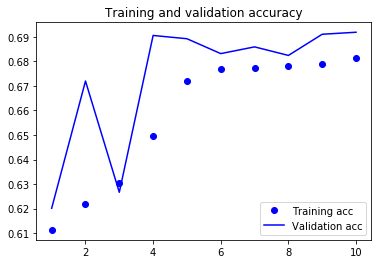

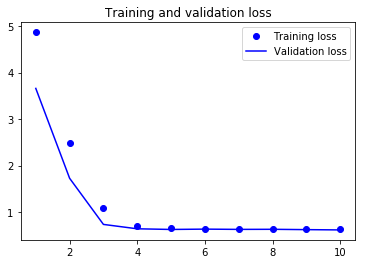

In [29]:
# Plot for Evaluation
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test Data
Now we will run model on test data, and with this simple model, we get 68% accuracy.

In [30]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

202175/202175 [==============================] - 4s 20us/step
test_acc: 0.6801582787201109
test_loss: 0.6263768313964985
